In [984]:
## import packages and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import statistics
import copy

training data

In [985]:
# import data
df = pd.read_csv("data/test_dataset.csv")
data = df.to_numpy()
(l, w) = data.shape

In [986]:
x_train = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = data[i, d]
        # update output array
        if p == 0:
            # print("shouldn't be here")
            missing_ind = np.random.choice(2, 1)[0]
            x_train[i, d*2] = missing_ind
            x_train[i, d*2+1] = missing_ind
        else:
            x_train[i, d*2] = p # score
            x_train[i, d*2+1] = 1-p # 1-score

In [987]:
# x_train = data.reshape((-1, 28))
# x_train.shape

In [988]:
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(x_train, test_size=0.20)

Autoencoder model

In [989]:
(l, w)

(500, 2)

In [990]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n_domains = 2
         
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(n_domains * 2, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1)
        )
         
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, n_domains * 2),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [991]:
# Model Initialization
model = AE()
 
# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)

In [992]:
def missing(arr):
    return arr[0] == arr[1] and arr[0] == 0

In [993]:
epochs = 150
outputs = []
losses = []
val_losses = []
epoch_loss = []
val_epoch_loss = []

for epoch in range(epochs):
    for session in x_train:

      # Output of Autoencoder
      session_rs = session.reshape(-1, w * 2)
      session_t = torch.from_numpy(session_rs)
      session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
      reconstructed = model(session_t)

      # handle missing value
      missing_exists = False
      missing_domains = []
      for domain in range(w):
        if missing(session[domain*2:domain*2+2]):
          missing_exists = True
          missing_domains.append(domain)
          
      if missing_exists:
        session_dc = copy.deepcopy(session)
        for d in missing_domains:
          target = reconstructed.detach().numpy()[0][d*2:d*2+2]
          session_dc[d*2:d*2+2] = target
        session_dc = session_dc.reshape(-1, w * 2)
        session_t = torch.from_numpy(session_dc)
        session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
       
      # Calculating the loss function
      loss = loss_function(reconstructed, session_t)
       
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
       
      # Storing the losses in a list for plotting
      epoch_loss.append(loss.item())

    losses.append(statistics.mean(epoch_loss))
    epoch_loss = []
    outputs.append((epochs, session_t, reconstructed))

    with torch.no_grad():
      for val in x_val:
        val_rs = val.reshape(-1, w * 2)
        val_t = torch.from_numpy(val_rs)
        val_t = val_t.clone().detach().type(torch.float32)
        answer = model(val_t)
        val_loss = loss_function(answer, val_t)
        val_epoch_loss.append(val_loss.item())
    val_losses.append(statistics.mean(val_epoch_loss))

Epoch [1/150], Loss: 0.0929
Epoch [1/150], Loss: 0.1302
Epoch [1/150], Loss: 0.1216
Epoch [1/150], Loss: 0.2342
Epoch [1/150], Loss: 0.1096
Epoch [1/150], Loss: 0.1703
Epoch [1/150], Loss: 0.0901
Epoch [1/150], Loss: 0.0553
Epoch [1/150], Loss: 0.0220
Epoch [1/150], Loss: 0.1357
Epoch [1/150], Loss: 0.1456
Epoch [1/150], Loss: 0.0701
Epoch [1/150], Loss: 0.0337
Epoch [1/150], Loss: 0.0334
Epoch [1/150], Loss: 0.0093
Epoch [1/150], Loss: 0.2444
Epoch [1/150], Loss: 0.0353
Epoch [1/150], Loss: 0.0913
Epoch [1/150], Loss: 0.0339
Epoch [1/150], Loss: 0.0214
Epoch [1/150], Loss: 0.1771
Epoch [1/150], Loss: 0.1594
Epoch [1/150], Loss: 0.0699
Epoch [1/150], Loss: 0.0676
Epoch [1/150], Loss: 0.1443
Epoch [1/150], Loss: 0.0983
Epoch [1/150], Loss: 0.2135
Epoch [1/150], Loss: 0.2147
Epoch [1/150], Loss: 0.0571
Epoch [1/150], Loss: 0.0546
Epoch [1/150], Loss: 0.0992
Epoch [1/150], Loss: 0.0563
Epoch [1/150], Loss: 0.1079
Epoch [1/150], Loss: 0.0925
Epoch [1/150], Loss: 0.1702
Epoch [1/150], Loss:

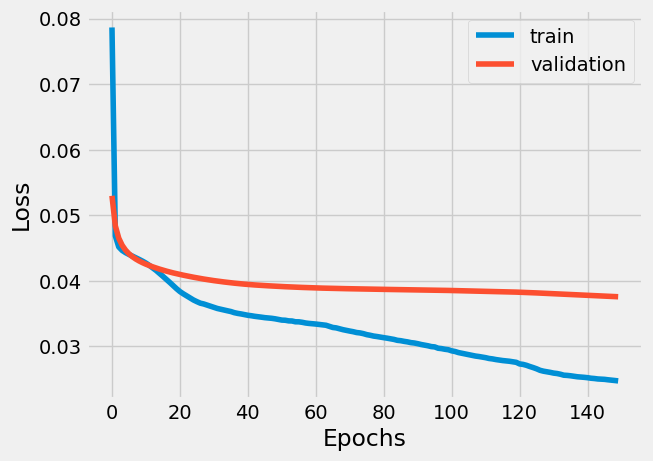

In [994]:
 # Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting
with torch.no_grad():
   plt.plot(losses)
   plt.plot(val_losses)
   plt.legend(["train", "validation"])

Debug

In [995]:
temp = np.array([1.0, 1.0, 1.0, 1.0])

In [996]:
# Output of Autoencoder
temp = temp.reshape(-1, w * 2)
temp = torch.from_numpy(temp)
temp = temp.clone().detach().requires_grad_(True).type(torch.float32)
reconstructed = model(temp)
print(temp)
print(reconstructed)

# handle missing value
# missing_exists = False
# missing_domains = []
# for domain in range(w):
#     if missing(temp[domain*2:domain*2+2]):
#         missing_exists = True
#         missing_domains.append(domain)
# print(missing_exists, missing_domains)
# if missing_exists:
#     session_dc = copy.deepcopy(temp)
#     for d in missing_domains:
#         target = reconstructed.detach().numpy()[0][d*2:d*2+2]
#         print(d, target)
#         session_dc[d*2:d*2+2] = target
#     session_dc = session_dc.reshape(-1, w * 2)
#     session_t = torch.from_numpy(session_dc)
#     session_t = session_t.clone().detach().requires_grad_(True).type(torch.float32)
#     print(session_t)

tensor([[1., 1., 1., 1.]], grad_fn=<ToCopyBackward0>)
tensor([[0.3983, 0.6450, 0.6349, 0.4344]], grad_fn=<SigmoidBackward0>)


In [997]:
np.mean(x_train, axis=0)

array([0.48983528, 0.51266472, 0.48743498, 0.52506502])

Testing all missing average

In [998]:
missing_data = pd.read_csv("data/all_missing_500.csv")
missing_data = missing_data.to_numpy()
(l, w) = missing_data.shape

In [999]:
missing_set = np.zeros((l, w*2))
for i in range(l):
    for d in range(w):
        p = missing_data[i, d]
        # update output array
        missing_set[i, d*2] = p
        missing_set[i, d*2+1] = p
missing_set

array([[1., 1., 0., 0.],
       [0., 0., 1., 1.],
       [0., 0., 1., 1.],
       ...,
       [0., 0., 0., 0.],
       [1., 1., 0., 0.],
       [1., 1., 0., 0.]])

In [1000]:
total = np.array([0.0, 0.0, 0.0, 0.0])
for row in missing_set:
    temp = row.reshape(-1, w * 2)
    temp = torch.from_numpy(temp)
    temp = temp.clone().detach().requires_grad_(True).type(torch.float32)
    output = model(temp).detach().numpy()[0]
    total = output + total

total = total/l
total

array([0.57256656, 0.44682654, 0.4133477 , 0.64152811])

In [1001]:
### generate all missing dataset
# n_samples = 500
# f1 = np.random.choice(2, (n_samples, 1))
# f2 = np.random.choice(2, (n_samples, 1))
# arr = np.hstack((f1, f2))

# df = pd.DataFrame(arr)
# df.to_csv("data/all_missing_500.csv", index=False)